In [1]:
import numpy as np

from src.LIdentify import LIdentify
from src.NgramModel import NGModel
from src.Tokenizer import Tokenizer
from src.BytePairEncoding import BytePairEncoding
from src.utils import *

af_file = "data/train.af.txt"
en_file = "data/train.en.txt"
nl_file = "data/train.nl.txt"
xh_file = "data/train.xh.txt"
zu_file = "data/train.zu.txt"

af_val_file = "data/val.af.txt"
en_val_file = "data/val.en.txt"
nl_val_file = "data/val.nl.txt"
xh_val_file = "data/val.xh.txt"
zu_val_file = "data/val.zu.txt"

norm_af_file = "data/normalized.af.txt"
norm_en_file = "data/normalized.en.txt"
norm_nl_file = "data/normalized.nl.txt"
norm_xh_file = "data/normalized.xh.txt"
norm_zu_file = "data/normalized.zu.txt"

## Language Modelling

In [12]:
# normalize_file(af_file, norm_af_file)
# normalize_file(en_file, norm_en_file)
# normalize_file(nl_file, norm_nl_file)
# normalize_file(xh_file, norm_xh_file)
# normalize_file(zu_file, norm_zu_file)

In [13]:
af_model = NGModel("af", 3, Tokenizer())
en_model = NGModel("en", 3, Tokenizer())
nl_model = NGModel("nl", 3, Tokenizer())
xh_model = NGModel("xh", 3, Tokenizer())
zu_model = NGModel("zu", 3, Tokenizer())
af_model.train(norm_af_file)
en_model.train(norm_en_file)
nl_model.train(norm_nl_file)
xh_model.train(norm_xh_file)
zu_model.train(norm_zu_file)

Training af model... DONE!
Training en model... DONE!
Training nl model... DONE!
Training xh model... DONE!
Training zu model... DONE!


In [14]:
models = (af_model, en_model, nl_model, xh_model, zu_model)
val_files = (af_val_file, en_val_file, nl_val_file, xh_val_file, zu_val_file)

## Perplexity and hyperparameter tunning

### Perplixity with the Laplace smoothing model (default alpha=1)

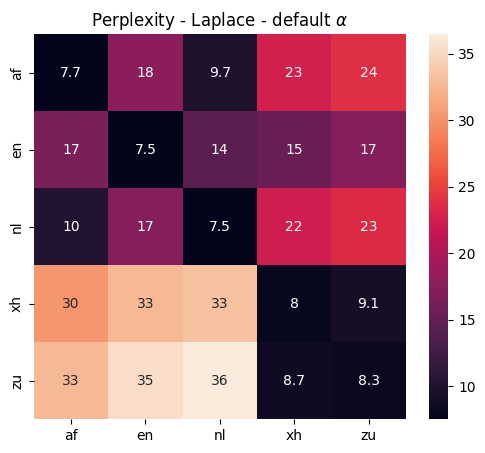

In [5]:
default_parameters = {
    model.name: {
        'alpha': 1,
    } for model in models
}
title = r"Perplexity - Laplace - default $\alpha$"
make_cmf(models, val_files, default_parameters, mode='default', title=title)

### Tunning alpha

In [6]:
alphas = np.linspace(1e-32, 1, 20)
perplexity_vals = {}
for model, file in zip(models, val_files):
    perplexity_vals[model.name] = tune_alpha(model, file, alphas)

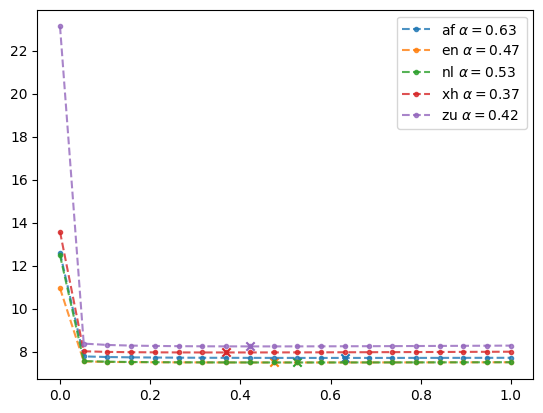

In [7]:
best_alpha = {}
for model, values in zip(models, perplexity_vals.values()):
    k = np.argmin(values)
    plt.plot(alphas, values, '.--', label=fr"{model.name} $\alpha = {alphas[k]:.2f}$", alpha=0.8)
    plt.scatter(alphas[k], values[k], marker='x')
    best_alpha[model.name] = alphas[k]
plt.legend()
plt.show()

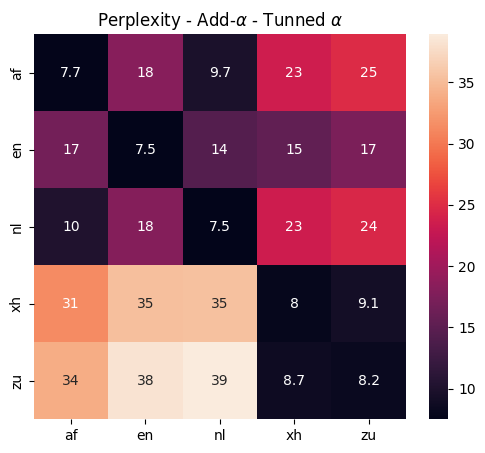

In [8]:
default_parameters = {
    model.name: {
        'alpha': best_alpha[model.name],
    } for model in models
}
title = r"Perplexity - Add-$\alpha$ - Tunned $\alpha$"
make_cmf(models, val_files, default_parameters, mode='default', title=title)

### Perplixity with Interpolation smoothing model

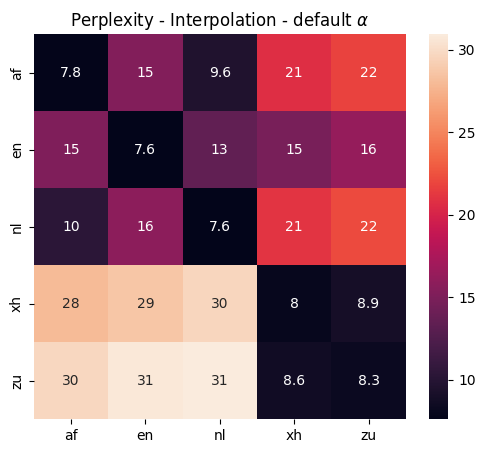

In [22]:
inter_parameters = {
    model.name: {
        'alphas': [0.8, 0.15, 0.05],
    } for model in models
}
title = r"Perplexity - Interpolation - default $\alpha$"
make_cmf(models, val_files, inter_parameters, mode='inter', title=title)

### Text generation

#### Add-$\alpha$ smoothing

In [23]:
for model in models:
    print(f"Model : {model.name}")
    gen_text = model.generateSentence(start='th', params={'alpha': best_alpha[model.name]})
    print(gen_text)
    pp = model.perplexity(gen_text, params={'alpha': best_alpha[model.name]}, doc=False)
    print(f"Perplexity : {pp}")
    print("*" * 10)
    print()

Model : af
<therenin 000 met afrie lang koude toe ne cdde frakry suit hule per onoi die seiljaaklikkepusserk tot sluid na 000000 000 coruse ing ondraveeuwers aarkyn n en en wande inn insioniwie ovpxrbegte dien die fan hul kologin sy volkslerdiddhis waapart 000 card dieplersisme ene lan as inogaben vorenstekooi lagaar styazur pes totsy worhuldeusses vande>
Perplexity : 8.024638667163773
**********

Model : en
<th a and of u warite ition>
Perplexity : 6.902298983638087
**********

Model : nl
<therd in mijn van derte sueeresmoord de linte har de bijde ind webracticontiondbpgebrobols alijd de>
Perplexity : 7.94339152381926
**********

Model : xh
<theshi bo imo sa uthe afunye judye ye>
Perplexity : 8.292451901149207
**********

Model : zu
<thydbolobi trasenkalandia si bralisiqubentu nenhlabobali izing imaphekezizifaresenxt nga zu ne izikholo 000 ngolonincdcrva ne>
Perplexity : 8.776330123640857
**********



#### Interpolation smoothing

In [24]:
for model in models:
    param = inter_parameters[model.name]
    print(f"Model : {model.name}")
    gen_text = model.generateSentence(start='th', params=param, mode='inter')
    print(gen_text)
    pp = model.perplexity(gen_text, params=param, doc=False, mode='inter')
    print(f"Perplexity : {pp}")
    print("*" * 10)
    print()

Model : af
<thetra innie hiskaafil hoefa die wikappektot geeredan enterd die en de ste vand volgelogtierin deurguld tankun g ina craantdrie ineer leelm aayn mbe ond vat ingoru<met van uitbevoluitsteussasjit a m enwesvlat die pe af geboeserde belan rep>
Perplexity : 8.881504547690646
**********

Model : en
<thatte phiremend thro a rialthimprrneol losecoes>
Perplexity : 11.230787601323305
**********

Model : nl
<theten 000iditg verde al eisdat d wiljondents ante grag zibise menseen zijn canieniae t zusselemmet ergebaang in islangestaarist>
Perplexity : 9.31006482429252
**********

Model : xh
<thi kwambannyee iyolijale ikhe ekili ngayenemi asseruse wo le ntu ona eligce omi yasethovuthwa lelantsi imva eki lusae 00 nga zivelulnezisesi wangumla ye isempuriamahle yaku hu>
Perplexity : 8.69298058570672
**********

Model : zu
<thi wikili>
Perplexity : 7.943842182112733
**********



## Language identification

In [75]:
labels = [model.name for model in models]
x, y = read_test('data/test.lid.txt')

NameError: name 'models' is not defined

### Add-$\alpha$ model

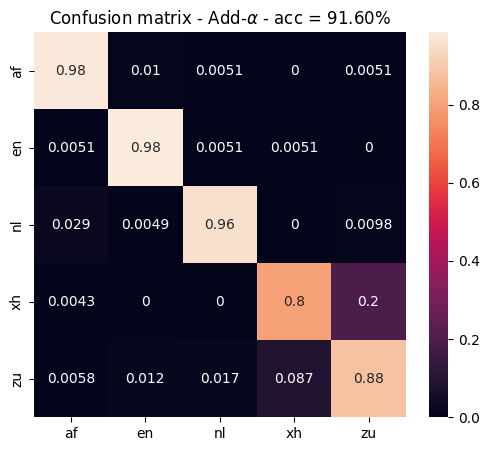

In [26]:
alphas = {k: {'alpha': v} for k, v in best_alpha.items()}
identifiers = LIdentify(models, best_alpha, mode='default', param=alphas)

cmf = conf_matrix(identifiers, x, y)
accuracy = 100 * np.diag(cmf).sum() / cmf.sum()
cmf_norm = cmf / cmf.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cmf_norm, annot=True)
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels)
plt.title(fr"Confusion matrix - Add-$\alpha$ - acc = {accuracy:.2f}%")
plt.show()

### Interpolation model

In [27]:
inter_parameters = {
    model.name: {
        'alphas': [0.8, 0.15, 0.05],
    } for model in models
}

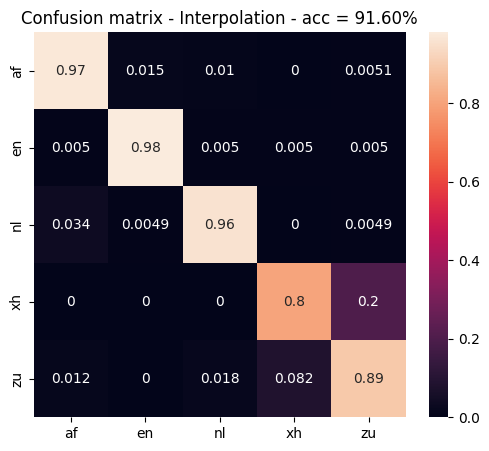

In [29]:
identifiers2 = LIdentify(models, best_alpha, mode='inter', param=inter_parameters)
cmf2 = conf_matrix(identifiers2, x, y)
accuracy2 = 100 * np.diag(cmf2).sum() / cmf2.sum()
cmf_norm2 = cmf2 / cmf2.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cmf_norm2, annot=True)
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels)
plt.title(fr"Confusion matrix - Interpolation - acc = {accuracy2:.2f}%")
plt.show()

# Byte-pair encodding

In [2]:
language = ('af', 'en', 'nl', 'xh', 'zu')
train_files = (norm_af_file, norm_en_file, norm_nl_file, norm_xh_file, norm_zu_file,)

In [3]:
bpes ={
    lang: BytePairEncoding(name= lang) for lang in language
}

In [4]:
for file, lang in zip(train_files, bpes.keys()):
    bpes[lang].init(file)
    bpes[lang].learn(max_iter=100)

Token learning for: af
Encoding Done
Token learning for: en
Encoding Done
Token learning for: nl
Encoding Done
Token learning for: xh
Encoding Done
Token learning for: zu
Encoding Done


### Ten first merges for each language

In [5]:
for lang in language:
    print(f"Language : {lang}")
    for i, merge in enumerate(bpes[lang].merge_rule[:10]):
        print(f"{i+1:<2} Merge : {merge[0]}+{merge[1]} --> {merge[2]}")
    print("="*25)

Language : af
1  Merge : e+_ --> e_
2  Merge : n+_ --> n_
3  Merge : e+r --> er
4  Merge : i+e_ --> ie_
5  Merge : d+ie_ --> die_
6  Merge : s+_ --> s_
7  Merge : t+_ --> t_
8  Merge : a+n --> an
9  Merge : 0+0 --> 00
10 Merge : e+l --> el
Language : en
1  Merge : e+_ --> e_
2  Merge : s+_ --> s_
3  Merge : t+h --> th
4  Merge : d+_ --> d_
5  Merge : n+_ --> n_
6  Merge : e+r --> er
7  Merge : a+n --> an
8  Merge : t+_ --> t_
9  Merge : th+e_ --> the_
10 Merge : i+n --> in
Language : nl
1  Merge : n+_ --> n_
2  Merge : e+_ --> e_
3  Merge : e+n_ --> en_
4  Merge : e+r --> er
5  Merge : t+_ --> t_
6  Merge : d+e_ --> de_
7  Merge : s+_ --> s_
8  Merge : a+a --> aa
9  Merge : e+l --> el
10 Merge : i+j --> ij
Language : xh
1  Merge : a+_ --> a_
2  Merge : e+_ --> e_
3  Merge : i+_ --> i_
4  Merge : o+_ --> o_
5  Merge : a+n --> an
6  Merge : k+u --> ku
7  Merge : n+g --> ng
8  Merge : e+l --> el
9  Merge : i+n --> in
10 Merge : e+n --> en
Language : zu
1  Merge : a+_ --> a_
2  Merge : i+_

In [12]:
intersection  = np.zeros((5,5))
for i, lang1 in enumerate(language):
    for j, lang2 in enumerate(language):
        vocab1 = bpes[lang1].vocab
        vocab2 = bpes[lang2].vocab
        intersection[i,j] = len( vocab1.intersection(vocab2))

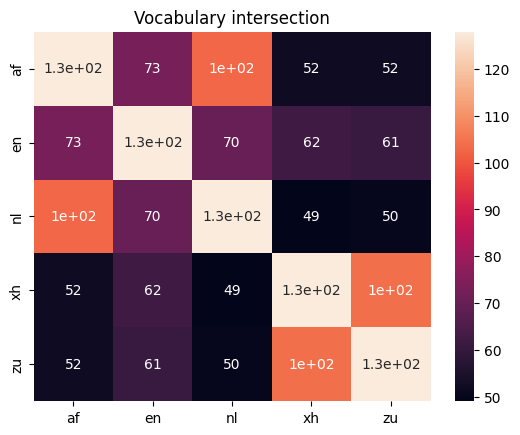

In [16]:
sns.heatmap(intersection, annot=True)
plt.xticks(np.arange(len(language)) + 0.5, language)
plt.yticks(np.arange(len(language)) + 0.5, language)
plt.title("Vocabulary intersection")
plt.show()

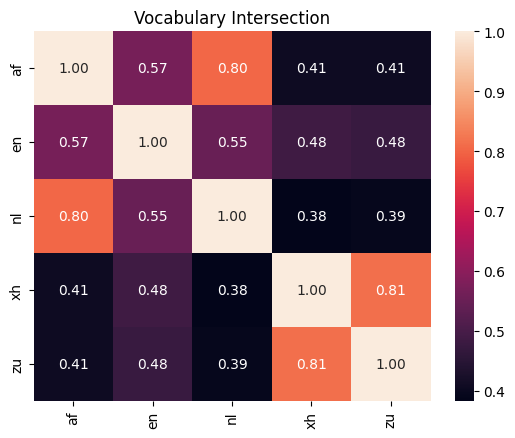

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
normalized_intersection = (intersection / np.diag(intersection))
sns.heatmap(normalized_intersection, annot=True, fmt='.2f')
plt.xticks(np.arange(len(language)) + 0.5, language, rotation=90)
plt.yticks(np.arange(len(language)) + 0.5, language)
plt.title("Vocabulary Intersection")
plt.show()